In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import wandb
from tqdm.notebook import tqdm
import random
import matplotlib.pyplot as plt
import copy
from torch.cuda.amp import autocast, GradScaler
import matplotlib.font_manager as fm

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
!wget -qq https://ektype.in/fontshost/Anek_Devanagari.zip
!unzip Anek_Devanagari.zip "static/AnekDevanagari/*"
!cp -r static/AnekDevanagari /usr/share/fonts/truetype

Archive:  Anek_Devanagari.zip
  inflating: static/AnekDevanagari/AnekDevanagari-Thin.ttf  
  inflating: static/AnekDevanagari/AnekDevanagari-ExtraLight.ttf  
  inflating: static/AnekDevanagari/AnekDevanagari-Light.ttf  
  inflating: static/AnekDevanagari/AnekDevanagari-Regular.ttf  
  inflating: static/AnekDevanagari/AnekDevanagari-Medium.ttf  
  inflating: static/AnekDevanagari/AnekDevanagari-SemiBold.ttf  
  inflating: static/AnekDevanagari/AnekDevanagari-Bold.ttf  
  inflating: static/AnekDevanagari/AnekDevanagari-ExtraBold.ttf  


In [3]:
font_path = '/usr/share/fonts/truetype/AnekDevanagari/AnekDevanagari-Regular.ttf'
font_prop = fm.FontProperties(fname=font_path)

In [4]:
!wget https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
!tar -xf dakshina_dataset_v1.0.tar

# Data paths
train_path = "dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv"
val_path = "dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv"
test_path = "dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv"

# Load data
train_df = pd.read_csv(train_path, delimiter='\t', names=['hi', 'en', '_'])
val_df = pd.read_csv(val_path, delimiter='\t', names=['hi', 'en', '_'])
test_df = pd.read_csv(test_path, delimiter='\t', names=['hi', 'en', '_'])

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

# Check max sequence lengths
src_max_len = max([len(str(text)) for text in train_df['en']])
tgt_max_len = max([len(str(text)) for text in train_df['hi']])
print(f"Max source sequence length: {src_max_len}")
print(f"Max target sequence length: {tgt_max_len}")

--2025-05-20 17:50:37--  https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.188.207, 74.125.195.207, 173.194.203.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.188.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008340480 (1.9G) [application/x-tar]
Saving to: ‘dakshina_dataset_v1.0.tar’

dakshina_dataset_v1 100%[===================>]   1.87G   180MB/s    in 9.4s    

2025-05-20 17:50:47 (204 MB/s) - ‘dakshina_dataset_v1.0.tar’ saved [2008340480/2008340480]

Train samples: 44204
Validation samples: 4358
Test samples: 4502
Max source sequence length: 20
Max target sequence length: 19


In [5]:
def create_vocab(texts, special_tokens=True):
    chars = set()
    for text in texts:
        for char in str(text):
            chars.add(char)
    
    # Create vocabulary dictionary
    if special_tokens:
        vocab = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3}
    else:
        vocab = {}
        
    for i, char in enumerate(sorted(list(chars))):
        vocab[char] = i + 4
    
    return vocab

def text_to_indices(text, vocab):
    indices = [vocab['<SOS>']]
    for char in str(text):
        if char in vocab:
            indices.append(vocab[char])
        elif char.lower() in vocab:
            indices.append(vocab[char.lower()])
        else:
            indices.append(vocab['<UNK>'])
    indices.append(vocab['<EOS>'])
    return indices

# Create vocabularies
src_vocab = create_vocab(train_df['en'])
tgt_vocab = create_vocab(train_df['hi'])

# Create reverse mappings for visualization
idx2src = {idx: char for char, idx in src_vocab.items()}
idx2tgt = {idx: char for char, idx in tgt_vocab.items()}

print(f"Source vocabulary size: {len(src_vocab)}")
print(f"Target vocabulary size: {len(tgt_vocab)}")

Source vocabulary size: 30
Target vocabulary size: 67


In [6]:
class TransliterationDataset(Dataset):
    def __init__(self, dataframe, src_vocab, tgt_vocab):
        self.dataframe = dataframe
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        src_text = self.dataframe.iloc[idx]['en']
        tgt_text = self.dataframe.iloc[idx]['hi']
        
        src_indices = text_to_indices(src_text, self.src_vocab)
        tgt_indices = text_to_indices(tgt_text, self.tgt_vocab)
        
        return torch.tensor(src_indices), torch.tensor(tgt_indices)

def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src, tgt in batch:
        # Safety check for index bounds
        src = torch.clamp(src, 0, len(src_vocab)-1)
        tgt = torch.clamp(tgt, 0, len(tgt_vocab)-1)
        
        # Pad or truncate to max lengths
        src = src[:20]  # Max source length is 20
        tgt = tgt[:19]  # Max target length is 19
        
        src_batch.append(src)
        tgt_batch.append(tgt)
    
    src_batch = pad_sequence(src_batch, batch_first=True, padding_value=src_vocab['<PAD>'])
    tgt_batch = pad_sequence(tgt_batch, batch_first=True, padding_value=tgt_vocab['<PAD>'])
    
    return src_batch, tgt_batch

In [7]:
class Encoder(nn.Module):
    def __init__(self, input_vocab_size, embedding_dim, hidden_dim, num_layers, dropout, cell_type):
        super().__init__()
        self.embedding = nn.Embedding(input_vocab_size, embedding_dim)
        self.cell_type = cell_type.lower()
        
        if self.cell_type == "lstm":
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, 
                              dropout=dropout if num_layers > 1 else 0, batch_first=True)
        elif self.cell_type == "gru":
            self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, 
                             dropout=dropout if num_layers > 1 else 0, batch_first=True)
        else:  # rnn
            self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers, 
                             dropout=dropout if num_layers > 1 else 0, batch_first=True)
        
        self.dropout = nn.Dropout(dropout)
        
        # Apply weight initialization
        self._init_weights()
        
    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
        
    def forward(self, src):
        # src: [batch_size, src_len]
        embedded = self.dropout(self.embedding(src))  # [batch_size, src_len, emb_dim]
        
        if self.cell_type == "lstm":
            outputs, (hidden, cell) = self.rnn(embedded)
            return outputs, hidden, cell
        else:
            outputs, hidden = self.rnn(embedded)
            return outputs, hidden, None

In [8]:
class AttentionDecoder(nn.Module):
    def __init__(self, output_vocab_size, embedding_dim, hidden_dim, num_layers, dropout, cell_type):
        super().__init__()
        self.output_vocab_size = output_vocab_size
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(output_vocab_size, embedding_dim)
        self.cell_type = cell_type.lower()
        
        # Attention mechanism
        self.attention = nn.Linear(hidden_dim * 2, hidden_dim)
        self.attention_combine = nn.Linear(hidden_dim + embedding_dim, embedding_dim)
        
        # RNN layer
        if cell_type == "lstm":
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, 
                              dropout=dropout if num_layers > 1 else 0, batch_first=True)
        elif cell_type == "gru":
            self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, 
                             dropout=dropout if num_layers > 1 else 0, batch_first=True)
        else:  # rnn
            self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers, 
                             dropout=dropout if num_layers > 1 else 0, batch_first=True)
        
        self.fc_out = nn.Linear(hidden_dim, output_vocab_size)
        self.dropout = nn.Dropout(dropout)
        
        # Apply weight initialization
        self._init_weights()
        
    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
        
    def forward(self, input, hidden, cell, encoder_outputs):
        # input: [batch_size]
        # hidden: [num_layers, batch_size, hidden_dim]
        # encoder_outputs: [batch_size, src_len, hidden_dim]
        
        input = input.unsqueeze(1)  # [batch_size, 1]
        embedded = self.dropout(self.embedding(input))  # [batch_size, 1, emb_dim]
        
        # Calculate attention weights
        batch_size = encoder_outputs.size(0)
        src_len = encoder_outputs.size(1)
        
        # Use the last layer of hidden state for attention
        attn_hidden = hidden[-1].unsqueeze(1)  # [batch_size, 1, hidden_dim]
        
        # Repeat for each encoder output
        attn_hidden = attn_hidden.repeat(1, src_len, 1)  # [batch_size, src_len, hidden_dim]
        
        # Concatenate encoder outputs and hidden state
        energy = torch.cat((encoder_outputs, attn_hidden), dim=2)  # [batch_size, src_len, 2*hidden_dim]
        energy = self.attention(energy)  # [batch_size, src_len, hidden_dim]
        energy = torch.tanh(energy)
        
        # Calculate attention weights
        attn_weights = torch.sum(energy, dim=2)  # [batch_size, src_len]
        attn_weights = F.softmax(attn_weights, dim=1).unsqueeze(1)  # [batch_size, 1, src_len]
        
        # Apply attention weights to encoder outputs
        context = torch.bmm(attn_weights, encoder_outputs)  # [batch_size, 1, hidden_dim]
        
        # Combine embedded input and context vector
        rnn_input = torch.cat((embedded, context), dim=2)  # [batch_size, 1, emb_dim + hidden_dim]
        rnn_input = self.attention_combine(rnn_input)  # [batch_size, 1, emb_dim]
        
        # Pass through RNN
        if self.cell_type == "lstm":
            output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        else:
            output, hidden = self.rnn(rnn_input, hidden)
            cell = None
            
        # Generate output
        prediction = self.fc_out(output.squeeze(1))  # [batch_size, output_vocab_size]
        
        return prediction, hidden, cell, attn_weights

In [9]:
class AttentionSeq2Seq(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.encoder = Encoder(
            config['input_vocab_size'],
            config['embedding_dim'],
            config['hidden_dim'],
            config['num_encoding_layers'],
            config['dropout'],
            config['cell_type']
        )
        self.decoder = AttentionDecoder(
            config['output_vocab_size'],
            config['embedding_dim'],
            config['hidden_dim'],
            config['num_decoding_layers'],
            config['dropout'],
            config['cell_type']
        )
        self.device = config.get('device', device)
        self.teacher_forcing_ratio = config.get('teacher_forcing_ratio', 0.5)
        self.cell_type = config['cell_type'].lower()
        self.config = config
        
    def forward(self, src, trg, teacher_forcing=1):
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_vocab_size
        
        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        
        # Tensor to store attention weights
        attentions = torch.zeros(batch_size, trg_len, src.shape[1]).to(self.device)
        
        # Encode source sequence
        encoder_outputs, hidden, cell = self.encoder(src)
        
        # Adjust hidden state dimensions if needed
        enc_layers = self.config['num_encoding_layers']
        dec_layers = self.config['num_decoding_layers']
        hidden_size = self.config['hidden_dim']
        
        if enc_layers != dec_layers:
            if self.cell_type != 'lstm':
                # Case 1: Encoder has more layers - take only what we need
                if enc_layers > dec_layers:
                    hidden = hidden[:dec_layers]
                # Case 2: Decoder has more layers - pad with zeros
                else:
                    padding = torch.zeros(dec_layers - enc_layers, batch_size, hidden_size).to(self.device)
                    hidden = torch.cat([hidden, padding], dim=0)
            else:  # LSTM case
                if enc_layers > dec_layers:
                    hidden = hidden[:dec_layers]
                    cell = cell[:dec_layers]
                else:
                    padding = torch.zeros(dec_layers - enc_layers, batch_size, hidden_size).to(self.device)
                    hidden = torch.cat([hidden, padding], dim=0)
                    cell = torch.cat([cell, padding], dim=0)
        
        # First input to decoder is <SOS> token
        input = trg[:, 0]
        
        for t in range(1, trg_len):
            # Get decoder output
            output, hidden, cell, attn_weights = self.decoder(input, hidden, cell, encoder_outputs)
            
            # Store prediction and attention weights
            outputs[:, t, :] = output
            attentions[:, t, :] = attn_weights.squeeze(1)
            
            # Teacher forcing
            teacher_force = random.random() < self.teacher_forcing_ratio * teacher_forcing
            
            # Get highest predicted token
            top1 = output.argmax(1)
            
            # Next input is either ground truth or predicted token
            input = trg[:, t] if teacher_force else top1
            
        return outputs, attentions

In [10]:

def train_epoch(model, dataloader, optimizer, criterion, scaler=None, clip=1.0):
    model.train()
    epoch_loss = 0
    
    for src, trg in tqdm(dataloader, desc="Training", leave=False):
        src, trg = src.to(device), trg.to(device)
        
        optimizer.zero_grad()
        
        # Mixed precision training
        if scaler:
            with autocast():
                output, _ = model(src, trg)
                
                # Exclude <SOS> token
                output_dim = output.shape[-1]
                output = output[:, 1:].reshape(-1, output_dim)
                trg = trg[:, 1:].reshape(-1)
                
                loss = criterion(output, trg)
                
            # Scale loss and backprop
            scaler.scale(loss).backward()
            
            # Unscale gradients and clip
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            
            # Update weights
            scaler.step(optimizer)
            scaler.update()
        else:
            output, _ = model(src, trg)
            
            # Exclude <SOS> token
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)
            
            loss = criterion(output, trg)
            loss.backward()
            
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            
            optimizer.step()
            
        epoch_loss += loss.item()
        
    return epoch_loss / len(dataloader)

In [11]:
def evaluate(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0
    
    # For exact match accuracy
    exact_match_correct = 0
    exact_match_total = 0
    
    # For character-level accuracy
    char_correct = 0
    char_total = 0
    
    with torch.no_grad():
        for src, trg in tqdm(dataloader, desc="Evaluating", leave=False):
            src, trg = src.to(device), trg.to(device)
            
            output, _ = model(src, trg, 0)  # Turn off teacher forcing
            
            # For loss calculation
            output_dim = output.shape[-1]
            output_flat = output[:, 1:].reshape(-1, output_dim)
            trg_flat = trg[:, 1:].reshape(-1)
            
            loss = criterion(output_flat, trg_flat)
            epoch_loss += loss.item()
            
            # Get predictions
            predictions = output.argmax(dim=2)
            
            # Calculate exact match and character-level accuracy
            for i in range(len(predictions)):
                pred_seq = predictions[i, 1:].cpu().numpy()  # Skip <SOS>
                target_seq = trg[i, 1:].cpu().numpy()  # Skip <SOS>
                
                # Get valid sequence (remove padding)
                valid_length = (target_seq != tgt_vocab['<PAD>']).sum()
                pred_clean = pred_seq[:valid_length]
                target_clean = target_seq[:valid_length]
                
                # Check exact match
                if np.array_equal(pred_clean, target_clean):
                    exact_match_correct += 1
                exact_match_total += 1
                
                # Calculate character-level accuracy
                for j in range(valid_length):
                    if pred_seq[j] == target_seq[j]:
                        char_correct += 1
                    char_total += 1
    
    # Calculate metrics
    exact_match_accuracy = exact_match_correct / exact_match_total if exact_match_total > 0 else 0
    char_accuracy = char_correct / char_total if char_total > 0 else 0
    
    return {
        'loss': epoch_loss / len(dataloader),
        'exact_match_accuracy': exact_match_accuracy,
        'char_accuracy': char_accuracy
    }

In [12]:
def translate_sentence(model, sentence, src_vocab, tgt_vocab, idx2tgt, max_len=50):
    model.eval()
    
    # Convert to indices and add <SOS> and <EOS>
    indices = text_to_indices(sentence, src_vocab)
    src_tensor = torch.LongTensor(indices).unsqueeze(0).to(device)
    
    # Get encoder outputs
    with torch.no_grad():
        encoder_outputs, hidden, cell = model.encoder(src_tensor)
    
    # Adjust hidden state dimensions if needed
    enc_layers = model.config['num_encoding_layers']
    dec_layers = model.config['num_decoding_layers']
    hidden_size = model.config['hidden_dim']
    
    if enc_layers != dec_layers:
        batch_size = 1  # Since we're translating one sentence
        if model.cell_type != 'lstm':
            if enc_layers > dec_layers:
                hidden = hidden[:dec_layers]
            else:
                padding = torch.zeros(dec_layers - enc_layers, batch_size, hidden_size).to(device)
                hidden = torch.cat([hidden, padding], dim=0)
        else:  # LSTM case
            if enc_layers > dec_layers:
                hidden = hidden[:dec_layers]
                cell = cell[:dec_layers]
            else:
                padding = torch.zeros(dec_layers - enc_layers, batch_size, hidden_size).to(device)
                hidden = torch.cat([hidden, padding], dim=0)
                cell = torch.cat([cell, padding], dim=0)
    
    # Start with <SOS> token
    trg_idx = [tgt_vocab['<SOS>']]
    attentions = []
    
    for _ in range(max_len):
        trg_tensor = torch.LongTensor([trg_idx[-1]]).to(device)
        
        with torch.no_grad():
            output, hidden, cell, attn_weights = model.decoder(trg_tensor, hidden, cell, encoder_outputs)
        
        # Store attention weights
        attentions.append(attn_weights.squeeze().cpu().numpy())
        
        pred_token = output.argmax(1).item()
        
        # Stop if <EOS> token
        if pred_token == tgt_vocab['<EOS>']:
            break
        
        trg_idx.append(pred_token)
    
    # Convert indices to characters
    trg_tokens = [idx2tgt[i] for i in trg_idx if i not in [tgt_vocab['<SOS>'], tgt_vocab['<EOS>'], tgt_vocab['<PAD>'], tgt_vocab['<UNK>']]]
    
    return ''.join(trg_tokens), attentions

In [13]:
def create_attention_grid(model, test_examples, src_vocab, tgt_vocab, idx2src, idx2tgt, rows=3, cols=3):
    """Create a grid of attention visualizations for test examples."""
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    examples = test_examples[:rows*cols]
    
    for i, example in enumerate(examples):
        row = i // cols
        col = i % cols
        
        # Get translation and attention matrix
        translation, attention_matrix = translate_sentence(
            model, example, src_vocab, tgt_vocab, idx2tgt
        )
        
        # Get source and target tokens
        src_tokens = [c for c in example]
        tgt_tokens = [c for c in translation]
        
        # Plot attention matrix
        attention = np.array(attention_matrix)[:len(tgt_tokens), :len(src_tokens)]
        im = axes[row, col].imshow(attention, cmap='gray')
        
        # Set labels
        axes[row, col].set_xticks(range(len(src_tokens)))
        axes[row, col].set_yticks(range(len(tgt_tokens)))
        axes[row, col].set_xticklabels(src_tokens, fontsize=8, fontproperties=font_prop)
        axes[row, col].set_yticklabels(tgt_tokens, fontsize=8, fontproperties=font_prop)
        axes[row, col].set_title(f"{example} to {translation}", fontsize=10, fontproperties=font_prop)
    
    plt.tight_layout()
    return fig

In [14]:
# Early stopping setup
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        """
        Args:
            patience: Number of epochs to wait if no improvement and then stop training
            min_delta: Minimum change in monitored value to qualify as improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        score = -val_loss  # Higher score is better (i.e., lower validation loss)
        
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:  # No improvement
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:  # Improvement
            self.best_score = score
            self.counter = 0
            
        return self.early_stop

In [15]:
def train_best_attention_model(config, epochs=40):
    # Initialize wandb run for final training
    run = wandb.init(project="seq2seq-attention-fffffinal123", name="best_attention_run")
    
    # Log the configuration
    wandb.config.update(config)
    
    # Create datasets
    train_dataset = TransliterationDataset(train_df, src_vocab, tgt_vocab)
    val_dataset = TransliterationDataset(val_df, src_vocab, tgt_vocab)
    test_dataset = TransliterationDataset(test_df, src_vocab, tgt_vocab)
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        collate_fn=collate_fn
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        collate_fn=collate_fn
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        collate_fn=collate_fn
    )
    
    # Initialize model
    model = AttentionSeq2Seq(config).to(device)
    
    
    # Optimizer and criterion
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<PAD>'])
    
    # Mixed precision training
    scaler = GradScaler() if device.type == 'cuda' else None
    
    # Training loop
    best_exact_match = 0
    best_model_state = None
    
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=10)
    
    for epoch in range(epochs):
        # Train
        train_loss = train_epoch(model, train_loader, optimizer, criterion, scaler)

        eval_metrics = evaluate(model, val_loader, criterion)
        
        # Log metrics
        wandb.log({
            'epoch': epoch,
            'train_loss': train_loss,
            'val_loss': eval_metrics['loss'],
            'val_exact_match': eval_metrics['exact_match_accuracy'],
            'val_char_accuracy': eval_metrics['char_accuracy']
        })
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {eval_metrics['loss']:.4f}")
        print(f"Exact Match Accuracy: {eval_metrics['exact_match_accuracy']:.4f}, Char Accuracy: {eval_metrics['char_accuracy']:.4f}")
        
        # Save best model and reset patience if improved
        if eval_metrics['exact_match_accuracy'] > best_exact_match:
            best_exact_match = eval_metrics['exact_match_accuracy']
            best_model_state = model.state_dict().copy()
            torch.save(model.state_dict(), 'best_attention_model_final.pt')
            wandb.save('best_attention_model_final.pt')
            
        # Check early stopping condition
        if early_stopping(eval_metrics['loss']):
            print("Early stopping triggered!")
            break
    
    # Load best model for testing
    model.load_state_dict(best_model_state)
    
    # Evaluate on test set
    test_metrics = evaluate(model, test_loader, criterion)
    
    # Log final test metrics
    wandb.run.summary['test_loss'] = test_metrics['loss']
    wandb.run.summary['test_exact_match'] = test_metrics['exact_match_accuracy']
    wandb.run.summary['test_char_accuracy'] = test_metrics['char_accuracy']
    
    print(f"\nFinal Test Results:")
    print(f"Test Loss: {test_metrics['loss']:.4f}")
    print(f"Test Exact Match Accuracy: {test_metrics['exact_match_accuracy']:.4f}")
    print(f"Test Character Accuracy: {test_metrics['char_accuracy']:.4f}")
    
    # Generate predictions and attention visualizations for test examples
    predictions = []
    for i in range(len(test_df)):
        src_text = test_df.iloc[i]['en']
        tgt_text = test_df.iloc[i]['hi']
        pred_text, attentions = translate_sentence(model, src_text, src_vocab, tgt_vocab, idx2tgt)
        
        predictions.append({
            'Source': src_text,
            'Target': tgt_text,
            'Prediction': pred_text,
            'Correct': pred_text == tgt_text
        })
        
    
    # Create a grid of attention visualizations
    test_examples = [test_df.iloc[i]['en'] for i in range(9)]
    grid_fig = create_attention_grid(model, test_examples, src_vocab, tgt_vocab, idx2src, idx2tgt)
    wandb.log({"test_attention_grid": wandb.Image(grid_fig)})
    
    # Create a table for predictions
    prediction_table = wandb.Table(dataframe=pd.DataFrame(predictions))
    wandb.log({"test_predictions": prediction_table})
    
    # Save predictions to file for assignment submission
    pd.DataFrame(predictions).to_csv('predictions_attention.csv')
    wandb.save('predictions_attention.csv')
    
    # Close wandb run
    wandb.finish()
    
    return model, pd.DataFrame(predictions)

In [17]:
!pip install wandb -q

import wandb
wandb.login(key='130161b8988911058327a18dbbdfb663c58411b2')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: da24m005 (da24m005-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [18]:
def get_best_config(project_name, entity="da24m005-iit-madras"):
    """
    Retrieves the best configuration from a wandb sweep based on validation accuracy.
    
    Args:
        project_name (str): The name of your wandb project
        entity (str, optional): Your wandb username/entity
    
    Returns:
        dict: The configuration of the best performing run
    """
    api = wandb.Api()
    path = f"{entity}/{project_name}" if entity else project_name
    runs = api.runs(path)
    
    best_run = None
    best_metric = float('-inf')
    
    for run in runs:
        if run.state == "finished":
            # Check different possible metric names
            val_metric = (run.summary.get('val_exact_match') or 
                         run.summary.get('val_accuracy') or 
                         run.summary.get('best_val_accuracy'))
            
            if val_metric is not None and val_metric > best_metric:
                best_metric = val_metric
                best_run = run
    
    if best_run:
        print(f"Best run ID: {best_run.id}")
        print(f"Best run name: {best_run.name}")
        print(f"Best validation metric: {best_metric:.4f}")
        
        # Create a clean config dictionary
        best_config = {
            'input_vocab_size': len(src_vocab),
            'output_vocab_size': len(tgt_vocab),
            'embedding_dim': best_run.config['embedding_dim'],
            'hidden_dim': best_run.config['hidden_dim'],
            'num_encoding_layers': best_run.config['num_encoding_layers'],
            'num_decoding_layers': best_run.config['num_decoding_layers'],
            'dropout': best_run.config['dropout'],
            'cell_type': best_run.config['cell_type'],
            'teacher_forcing_ratio': best_run.config['teacher_forcing_ratio'],
            'learning_rate': best_run.config['learning_rate'],
            'batch_size': best_run.config['batch_size'],
            'device': device
        }
        
        print(f"Best config: {best_config}")
        return best_config
    else:
        print("No finished runs found.")
        return None

best_config = get_best_config('seq2seq-attention-transliteration')

Best run ID: 44fdzej7
Best run name: fine-sweep-35
Best validation metric: 0.4449
Best config: {'input_vocab_size': 30, 'output_vocab_size': 67, 'embedding_dim': 128, 'hidden_dim': 512, 'num_encoding_layers': 2, 'num_decoding_layers': 3, 'dropout': 0.3, 'cell_type': 'lstm', 'teacher_forcing_ratio': 0.9, 'learning_rate': 0.0006293179845087059, 'batch_size': 128, 'device': device(type='cuda')}


/tmp/ipykernel_35/1954002687.py:44: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if device.type == 'cuda' else None


Training:   0%|          | 0/346 [00:00<?, ?it/s]

/tmp/ipykernel_35/1710485381.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 1/40, Train Loss: 2.9606, Val Loss: 3.4232
Exact Match Accuracy: 0.0000, Char Accuracy: 0.1658


Training:   0%|          | 0/346 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 2/40, Train Loss: 2.2743, Val Loss: 2.3109
Exact Match Accuracy: 0.0285, Char Accuracy: 0.4234


Training:   0%|          | 0/346 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 3/40, Train Loss: 1.1187, Val Loss: 1.6521
Exact Match Accuracy: 0.2416, Char Accuracy: 0.6336


Training:   0%|          | 0/346 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 4/40, Train Loss: 0.6677, Val Loss: 1.4348
Exact Match Accuracy: 0.3045, Char Accuracy: 0.6785


Training:   0%|          | 0/346 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 5/40, Train Loss: 0.5300, Val Loss: 1.4343
Exact Match Accuracy: 0.3580, Char Accuracy: 0.7042


Training:   0%|          | 0/346 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 6/40, Train Loss: 0.4519, Val Loss: 1.4055
Exact Match Accuracy: 0.3777, Char Accuracy: 0.7139


Training:   0%|          | 0/346 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 7/40, Train Loss: 0.3961, Val Loss: 1.4042
Exact Match Accuracy: 0.3949, Char Accuracy: 0.7251


Training:   0%|          | 0/346 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 8/40, Train Loss: 0.3548, Val Loss: 1.4465
Exact Match Accuracy: 0.4027, Char Accuracy: 0.7266
EarlyStopping counter: 1 out of 10


Training:   0%|          | 0/346 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 9/40, Train Loss: 0.3181, Val Loss: 1.4081
Exact Match Accuracy: 0.4257, Char Accuracy: 0.7428
EarlyStopping counter: 2 out of 10


Training:   0%|          | 0/346 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 10/40, Train Loss: 0.2940, Val Loss: 1.4091
Exact Match Accuracy: 0.4293, Char Accuracy: 0.7438
EarlyStopping counter: 3 out of 10


Training:   0%|          | 0/346 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 11/40, Train Loss: 0.2659, Val Loss: 1.4254
Exact Match Accuracy: 0.4252, Char Accuracy: 0.7400
EarlyStopping counter: 4 out of 10


Training:   0%|          | 0/346 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 12/40, Train Loss: 0.2430, Val Loss: 1.4494
Exact Match Accuracy: 0.4259, Char Accuracy: 0.7443
EarlyStopping counter: 5 out of 10


Training:   0%|          | 0/346 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 13/40, Train Loss: 0.2224, Val Loss: 1.4769
Exact Match Accuracy: 0.4339, Char Accuracy: 0.7470
EarlyStopping counter: 6 out of 10


Training:   0%|          | 0/346 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 14/40, Train Loss: 0.2107, Val Loss: 1.4246
Exact Match Accuracy: 0.4419, Char Accuracy: 0.7527
EarlyStopping counter: 7 out of 10


Training:   0%|          | 0/346 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 15/40, Train Loss: 0.1949, Val Loss: 1.4770
Exact Match Accuracy: 0.4380, Char Accuracy: 0.7495
EarlyStopping counter: 8 out of 10


Training:   0%|          | 0/346 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 16/40, Train Loss: 0.1765, Val Loss: 1.5418
Exact Match Accuracy: 0.4426, Char Accuracy: 0.7492
EarlyStopping counter: 9 out of 10


Training:   0%|          | 0/346 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 17/40, Train Loss: 0.1695, Val Loss: 1.5386
Exact Match Accuracy: 0.4369, Char Accuracy: 0.7512
EarlyStopping counter: 10 out of 10
Early stopping triggered!


Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]


Final Test Results:
Test Loss: 1.5292
Test Exact Match Accuracy: 0.4256
Test Character Accuracy: 0.7504


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train_loss,█▆▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_char_accuracy,▁▄▇▇▇████████████
val_exact_match,▁▁▅▆▇▇▇▇█████████
val_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,16
test_char_accuracy,0.7504
test_exact_match,0.42559
test_loss,1.52916
train_loss,0.16953
val_char_accuracy,0.75122


,Source,Target,Prediction,Correct
0,ank,अंक,अंक,True
1,anka,अंक,अंका,False
2,ankit,अंकित,अंकित,True
3,anakon,अंकों,अनाकों,False
4,ankhon,अंकों,आंखों,False
5,ankon,अंकों,आंकों,False
6,angkor,अंकोर,अंगकोर,False
7,ankor,अंकोर,अंकोर,True
8,angaarak,अंगारक,अंगारक,True
9,angarak,अंगारक,अंगरक,False


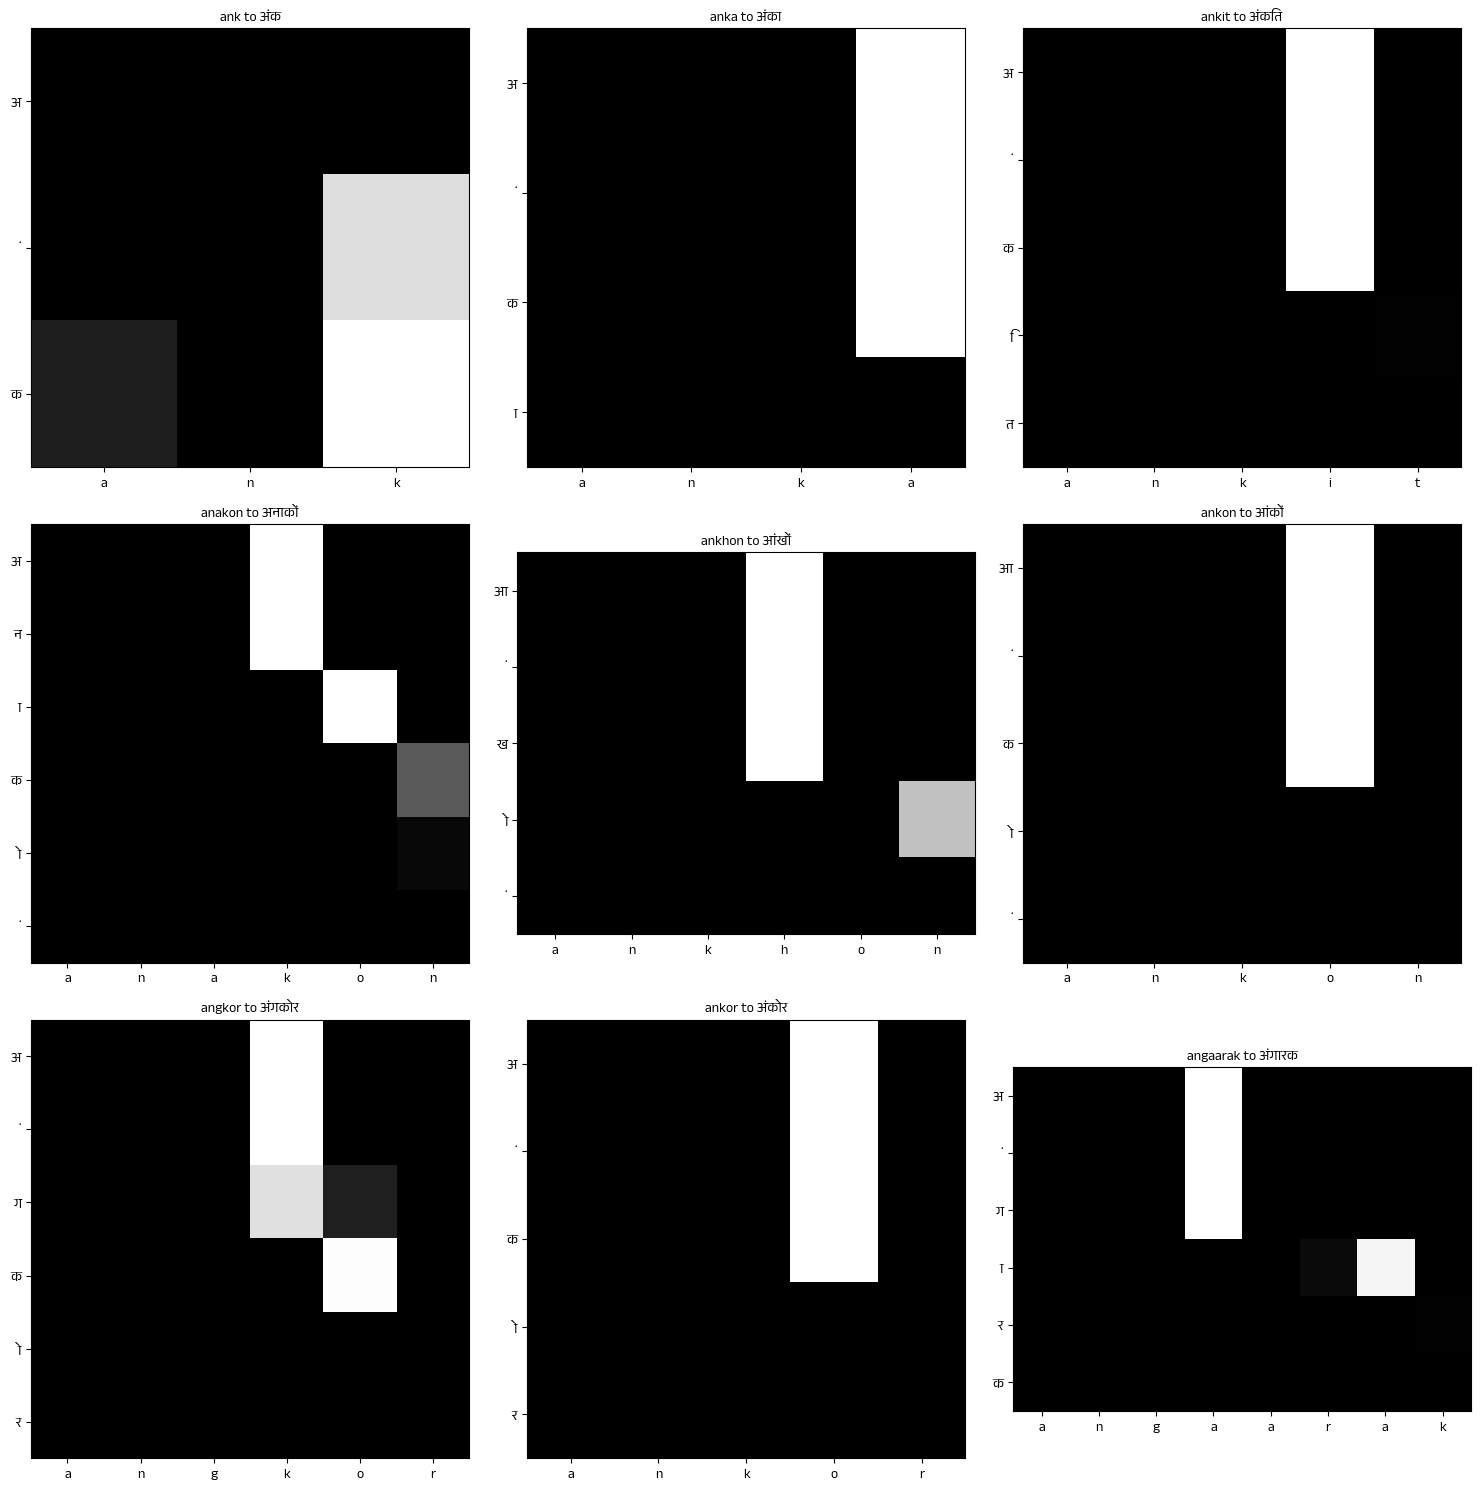

In [19]:
# Train the best model for 40 epochs
best_model, predictions = train_best_attention_model(best_config, epochs=40)

# Display some predictions
predictions.head(10)

In [20]:
predictions.to_csv('predictions_attention.csv')